In [1]:
import numpy as np
import pandas as pd
import numexpr
import itertools
from subprocess import call

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

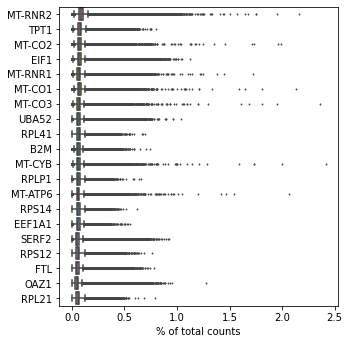

In [2]:
# DATA PROCESSING https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html?msclkid=9d2e34bcd04011ecb94b3611e5706065

import scanpy as sc
import os

if not os.path.isdir(r"data"):
    sc.datasets.pbmc3k()

adata = sc.read_h5ad("/mnt/biocluster/praktikum/neapss22/TS_immune.h5ad")
outdataname = "TS_immune"
#adata = sc.read_h5ad("data/wirka_data.h5ad")
#outdataname = "wirka"
sc.pl.highest_expr_genes(adata, n_top=20)

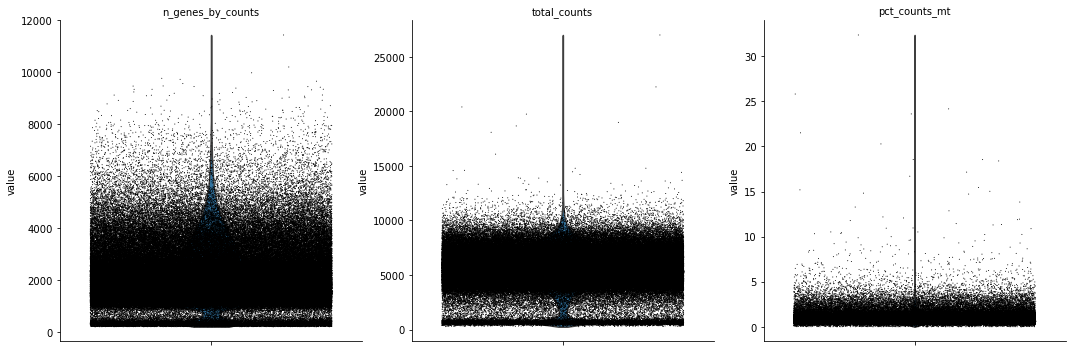

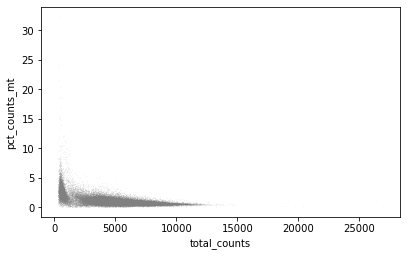

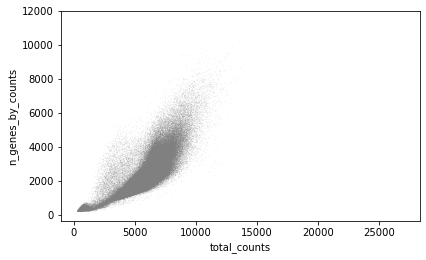

In [3]:
# filter genes

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


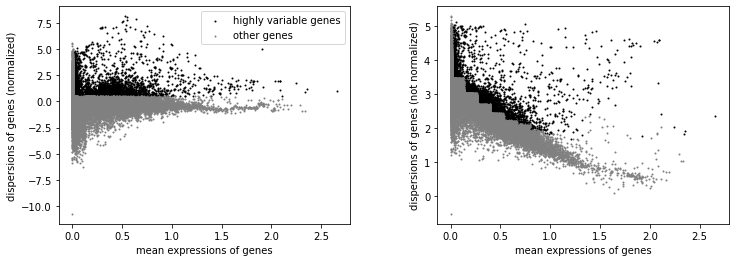

In [4]:
# slicing


adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
# Normalize by X to 10,000 reads per cell (count comparable)

sc.pp.normalize_total(adata, target_sum=1e4)

# logarithmize

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [5]:
# saving the raw data, then filtering

adata.raw = adata

adata = adata[:, adata.var.highly_variable]

In [6]:
# Regress out effects of total counts and percentage of mitochondrial genes expressed. Scaling data to unit variance
adata = adata.copy()
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

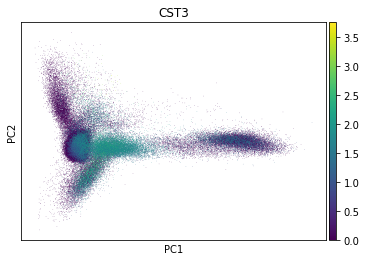

In [7]:
# PCA

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

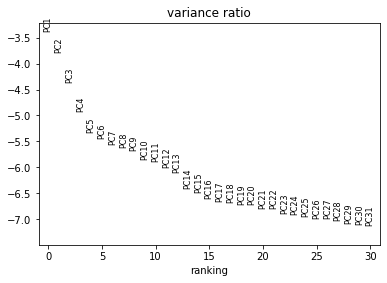

In [8]:
# elbow method

sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
# Neighbourhood graph

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


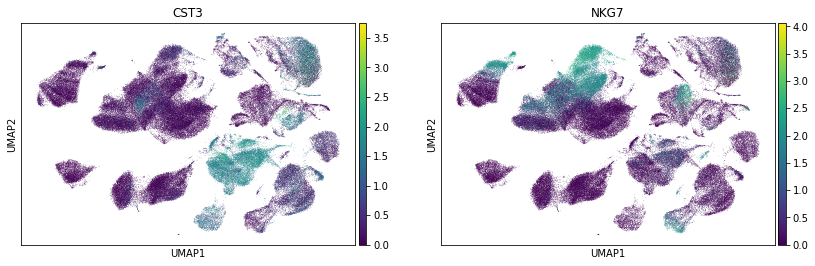

In [10]:
# UMAP data

sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7'])

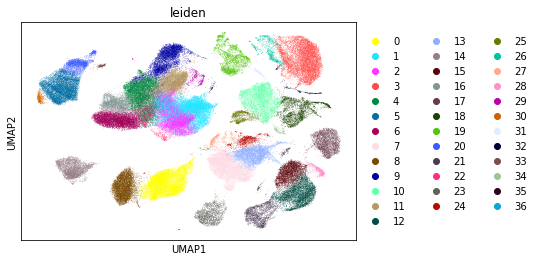

In [11]:
# Clustering

sc.tl.leiden(adata)
#sc.pl.umap(adata, color=['leiden', 'cell_ontology_class'])
sc.pl.umap(adata, color=['leiden'])

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWa

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

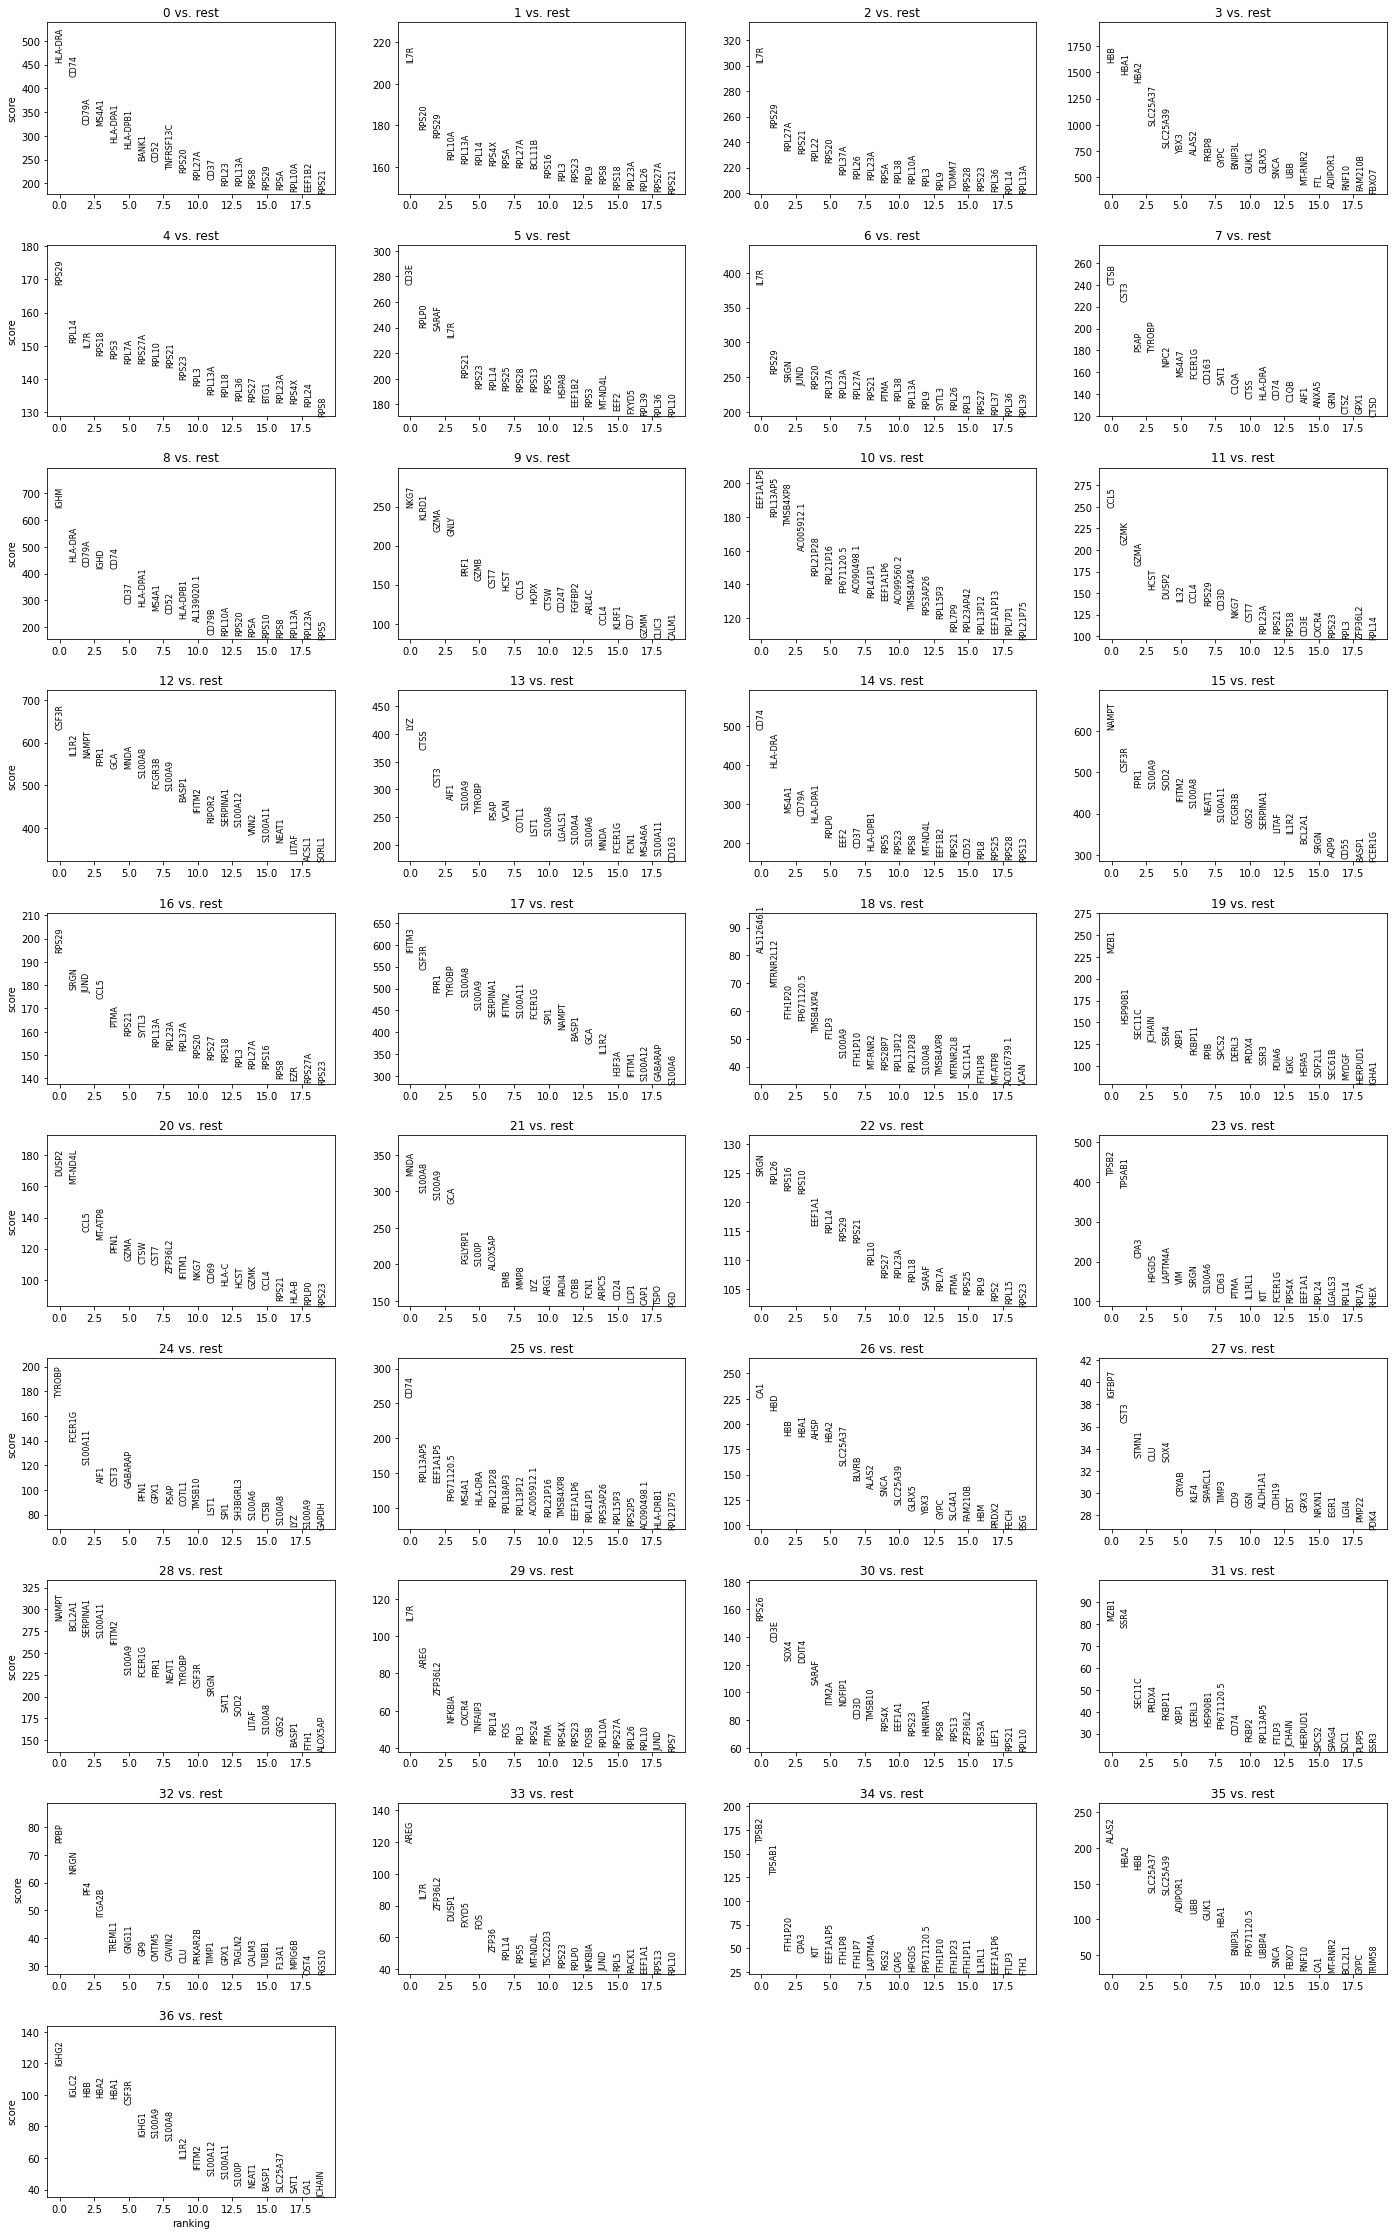

In [12]:
# Finding marker genes ==> t-test

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

ranking genes


/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarni

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: Performanc

    finished (0:11:55)


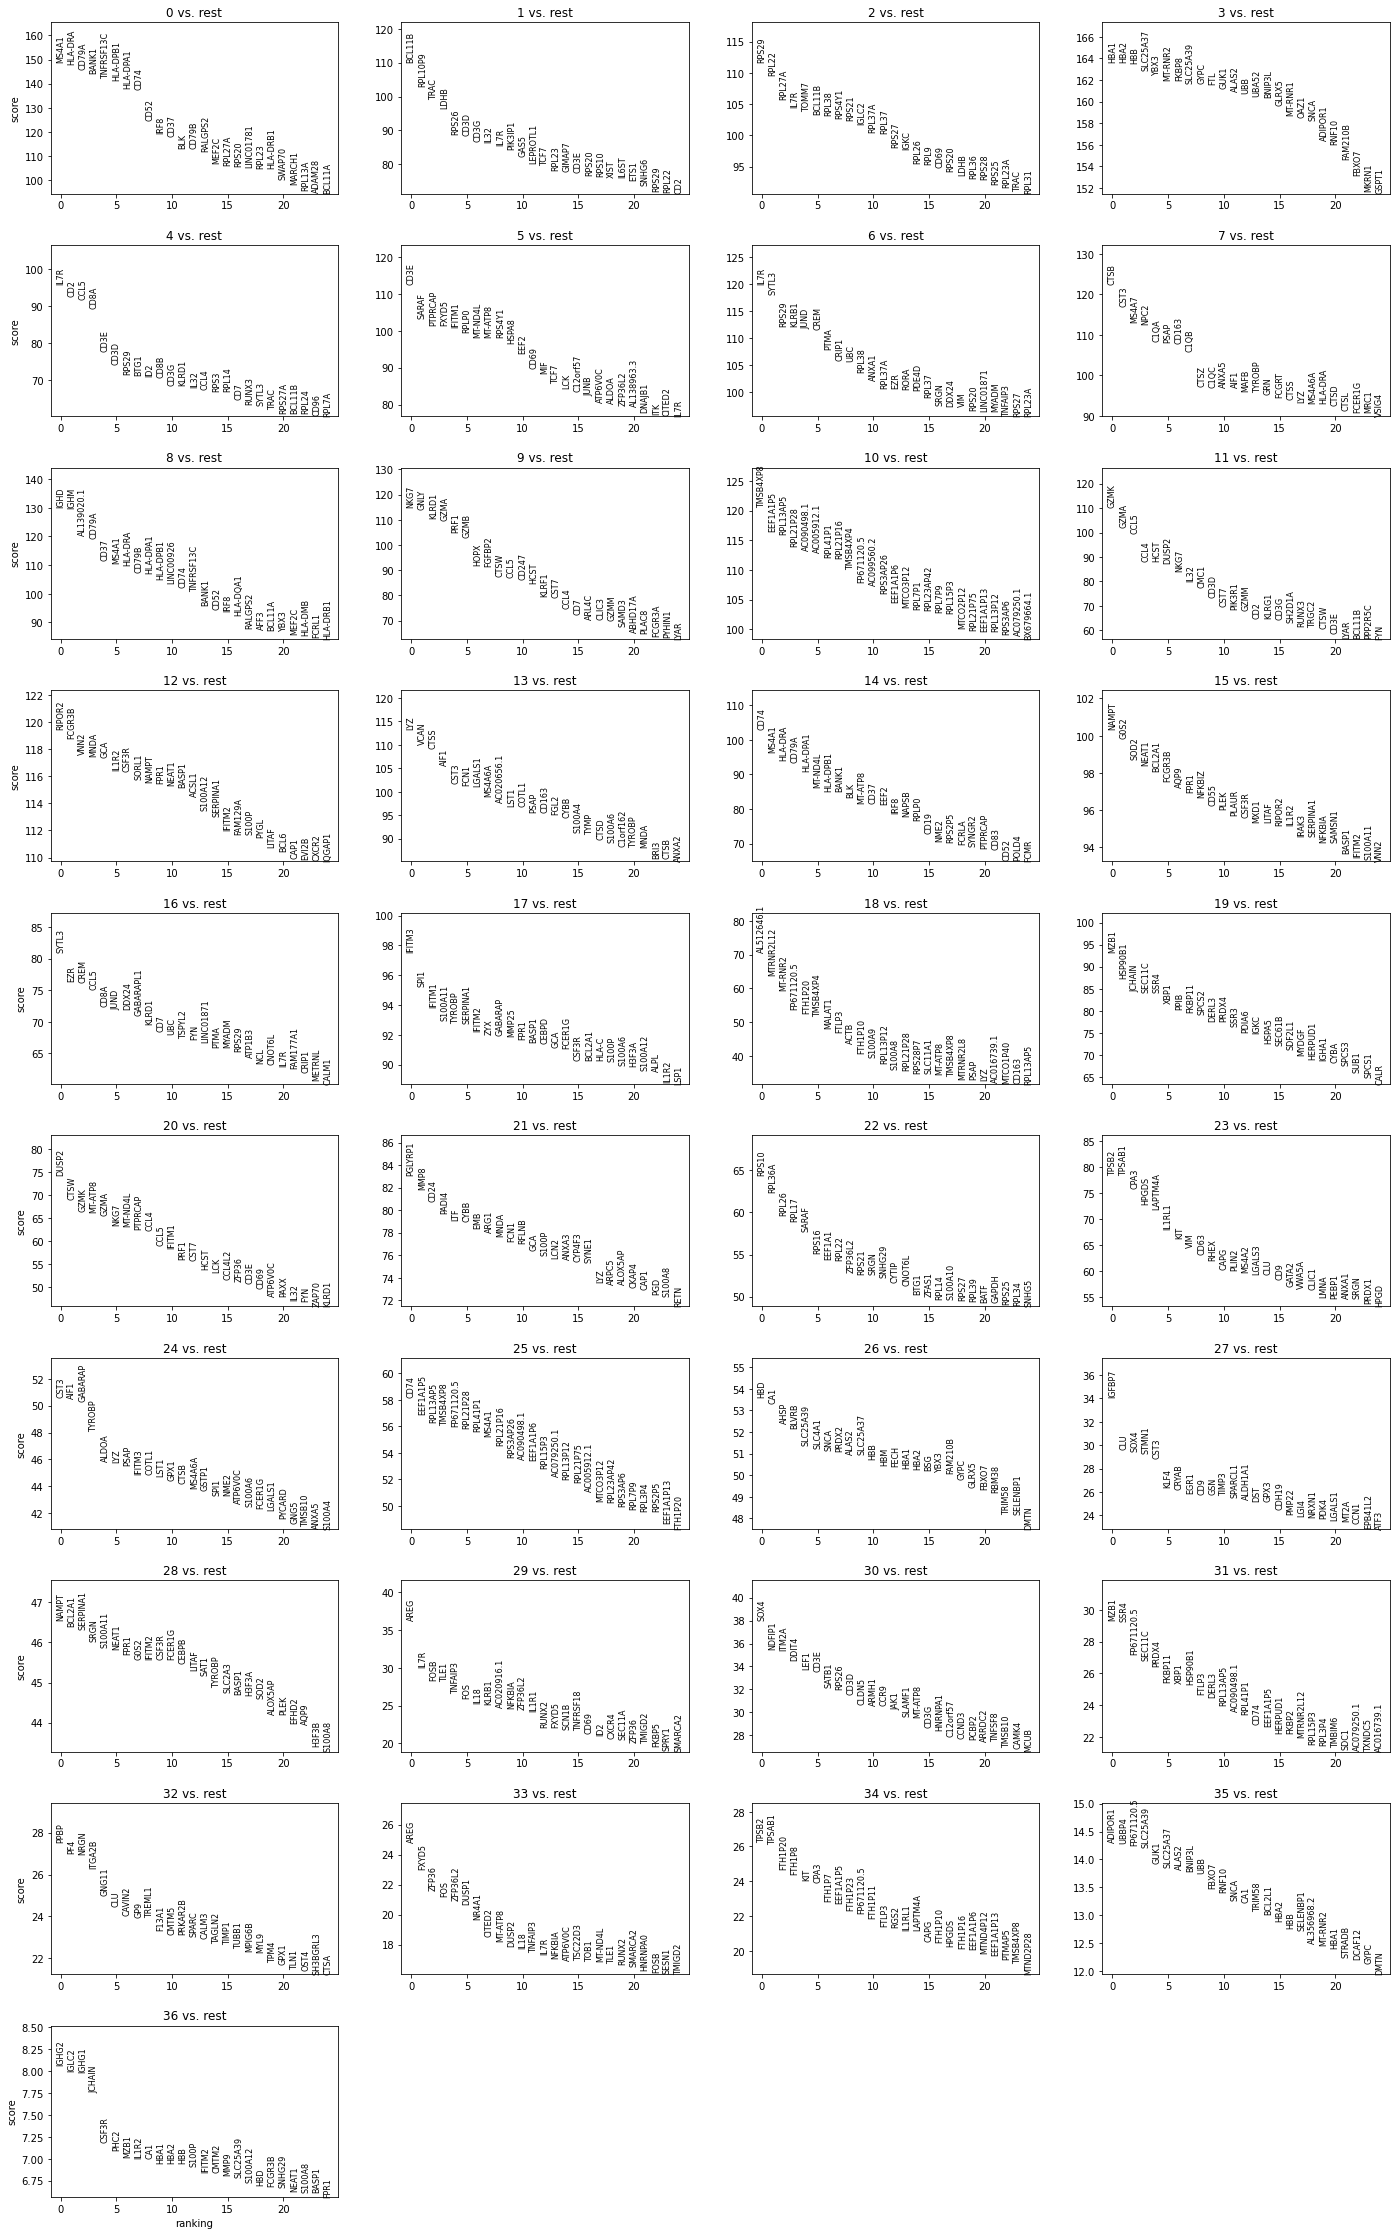

In [13]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    finished (0:13:32)


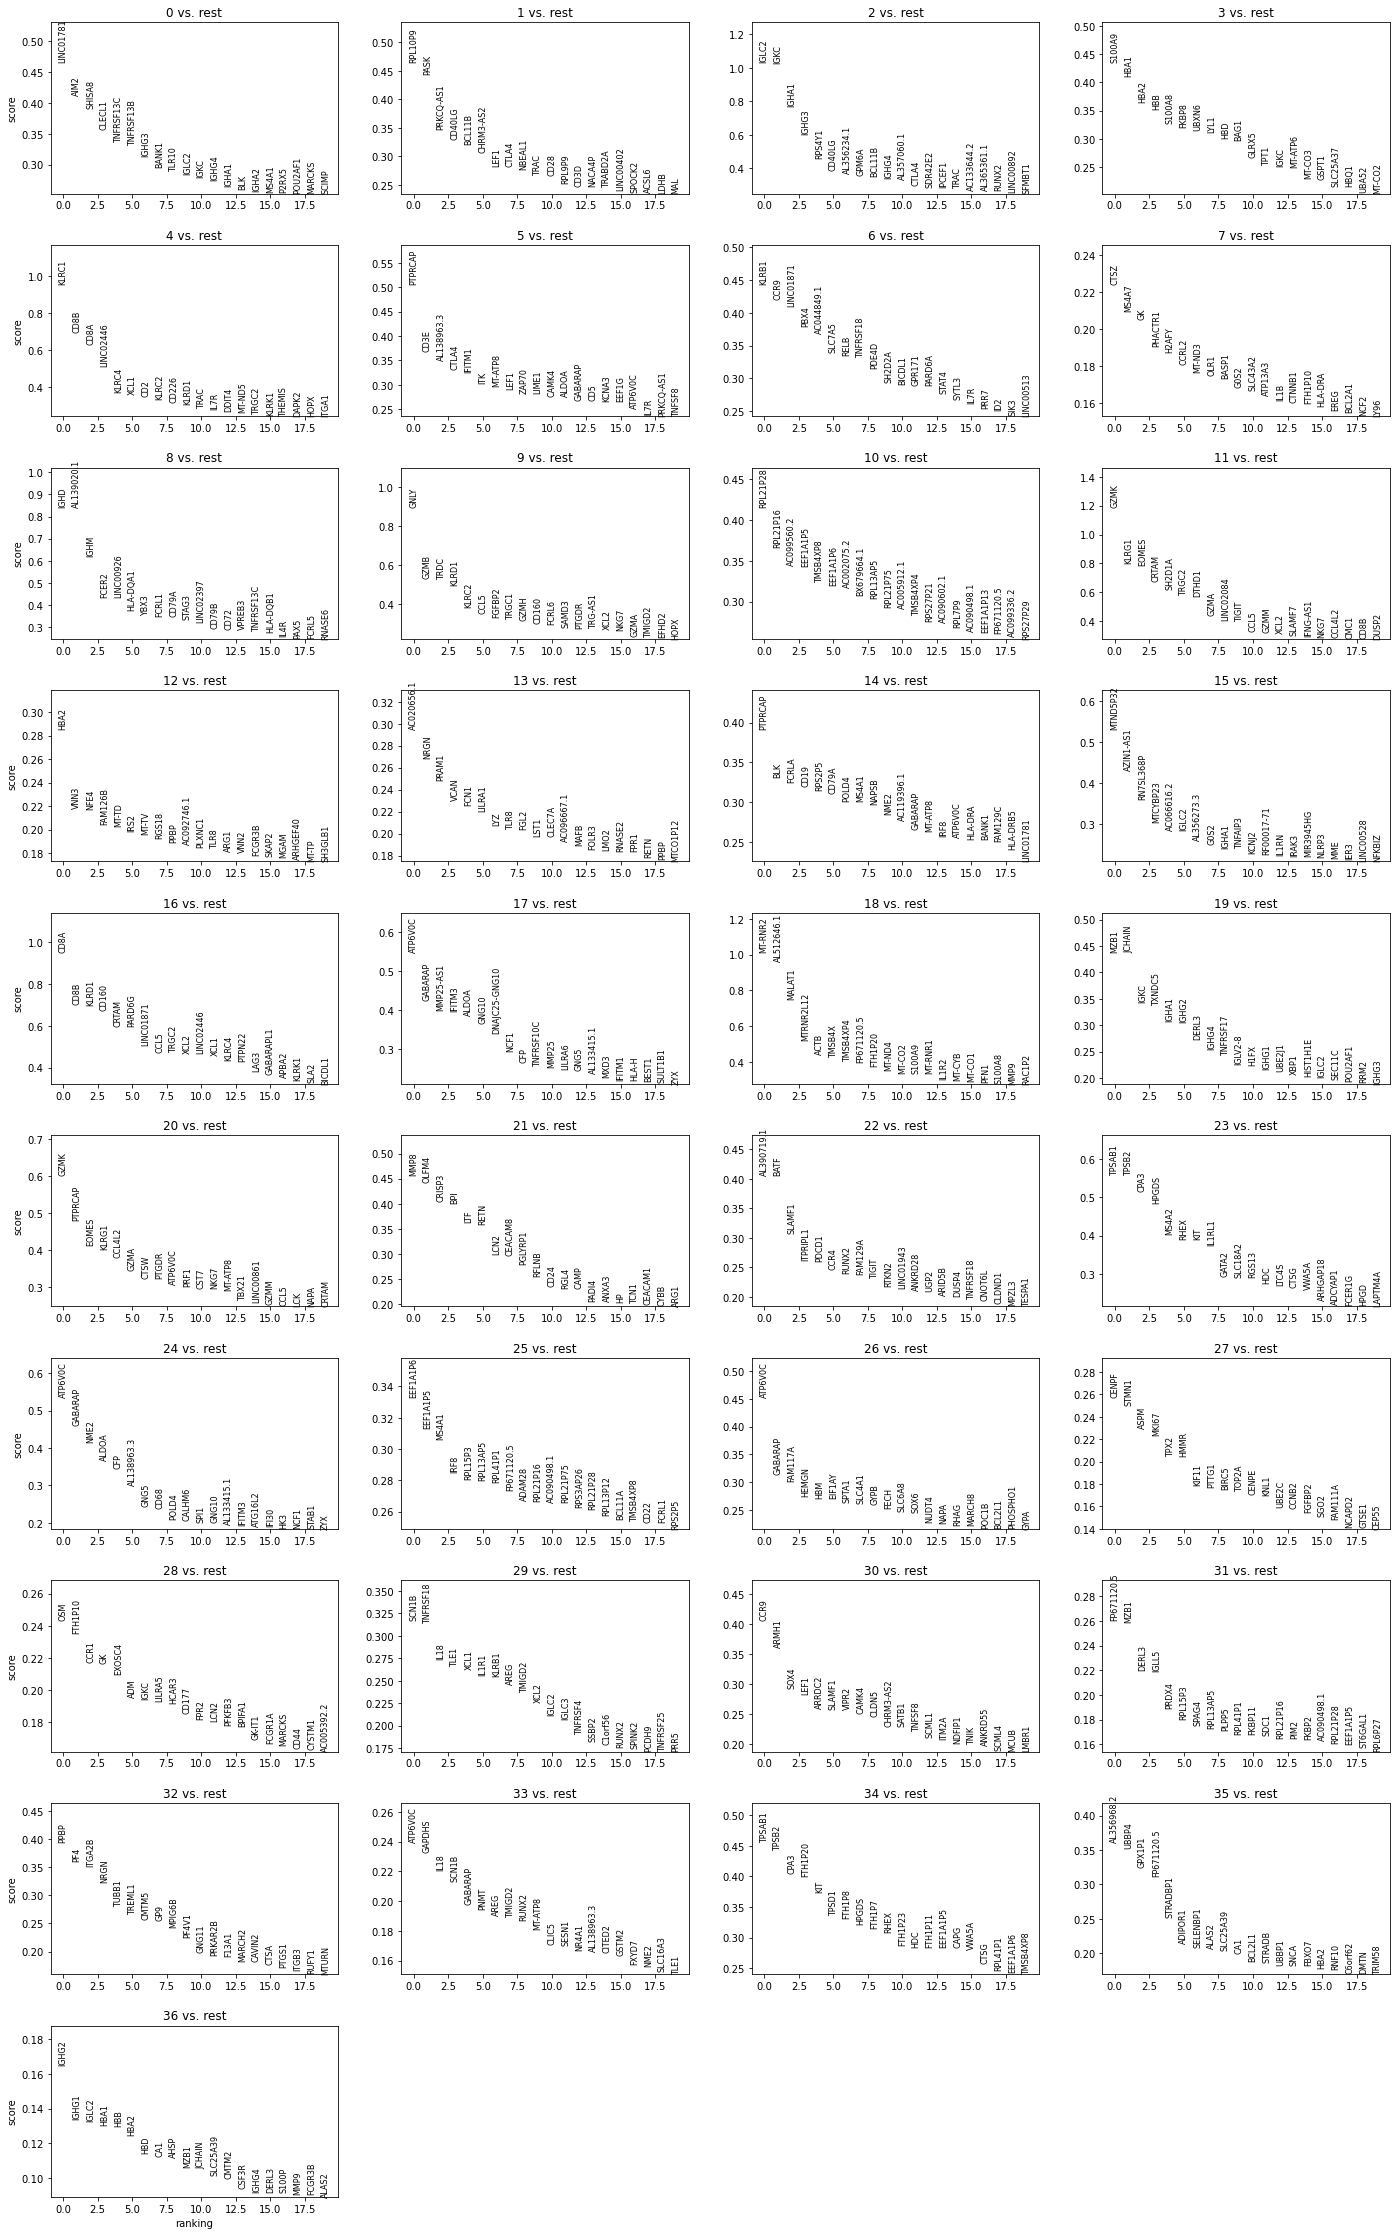

In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [15]:
adata

AnnData object with n_obs × n_vars = 147498 × 3801
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap', 'log1p', 'pca', '

In [ ]:
# https://github.com/JCVenterInstitute/NSForest
import graphviz
from NSForest_v3_mod import *

adata_markers = NS_Forest(adata, 'leiden')

36
0
LINC01781
2.9116251468658447
SHISA8
-0.168930321931839
Is Right Out!
VPREB3
2.56037974357605
AIM2
-0.2484901249408722
Is Right Out!
LINC02397
-0.1688041090965271
Is Right Out!
SPIB
-0.22510036826133728
Is Right Out!
POU2AF1
-0.2713156044483185
Is Right Out!
TLR10
-0.22372105717658997
Is Right Out!
AL139020.1
-0.25012052059173584
Is Right Out!
LINC00926
-0.2452557384967804
Is Right Out!
IGLC3
-0.25606614351272583
Is Right Out!
GNG7
-0.26698464155197144
Is Right Out!
IGHA2
-0.16749094426631927
Is Right Out!
YBX3
-0.4127952456474304
Is Right Out!
IGHG3
-0.28079989552497864
Is Right Out!
['LINC01781', 'VPREB3']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


3


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

1
LEF1
-0.31342437863349915
Is Right Out!
IGKC
-0.485971599817276
Is Right Out!
IGLC2
-0.47281450033187866
Is Right Out!
PASK
-0.3169821798801422
Is Right Out!
PRKCQ-AS1
-0.22117337584495544
Is Right Out!
MAL
-0.22497513890266418
Is Right Out!
IGHA1
-0.4920530915260315
Is Right Out!
GABARAP
-0.5830217003822327
Is Right Out!
PTPRCAP
-0.3747555613517761
Is Right Out!
ATP6V0C
-0.40592139959335327
Is Right Out!
MT-RNR1
0.2732008695602417
CD28
-0.3740572929382324
Is Right Out!
CHRM3-AS2
-0.31485387682914734
Is Right Out!
TRABD2A
-0.33632606267929077
Is Right Out!
ACSL6
-0.211395725607872
Is Right Out!
['MT-RNR1']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


1


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0


2
IGLC2
1.5001047849655151
IGKC
1.3465423583984375
IGHA1
1.0903449058532715
IGHG3
-0.30239740014076233
Is Right Out!
LEF1
-0.36004015803337097
Is Right Out!
MAL
-0.2690233588218689
Is Right Out!
AL357060.1
-0.38066160678863525
Is Right Out!
CAMK4
-0.4012985825538635
Is Right Out!
CD40LG
-0.32443544268608093
Is Right Out!
IGHG4
-0.23477080464363098
Is Right Out!
IPCEF1
-0.396828293800354
Is Right Out!
UBA52
0.4684469699859619
MT-RNR2
-0.24994930624961853
Is Right Out!
IGHM
-0.3980987071990967
Is Right Out!
GPM6A
-0.20073272287845612
Is Right Out!
['IGLC2', 'IGKC', 'IGHA1', 'UBA52']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


15


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

3
RNU6-6P
-0.15417444705963135
Is Right Out!
TMSB4XP2
-0.36526763439178467
Is Right Out!
SNORD13P3
-0.10025915503501892
Is Right Out!
AL136131.3
-0.03277256339788437
Is Right Out!
NUDT4B
-0.10152436792850494
Is Right Out!
PTGES3P3
-0.0530238077044487
Is Right Out!
AC099336.2
-0.418518602848053
Is Right Out!
BX322562.1
-0.10757289081811905
Is Right Out!
IGF2
-0.1275728940963745
Is Right Out!
AL390955.2
-0.08244042843580246
Is Right Out!
H2BFS
-0.0837012380361557
Is Right Out!
MTRNR2L12
-0.6292116641998291
Is Right Out!
AC090602.1
-0.4605444669723511
Is Right Out!
AC002075.2
-0.4627028703689575
Is Right Out!
AC008622.2
-0.14106450974941254
Is Right Out!
[]
0
NO MARKER GENE FOUND
4


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


KLRC1
-0.18703237175941467
Is Right Out!
CD8A
2.2055916786193848
CD8B
2.172593116760254
XCL1
-0.2226032316684723
Is Right Out!
CXCR6
-0.25442808866500854
Is Right Out!
LINC02446
-0.14416930079460144
Is Right Out!
LGALS3
-0.15445619821548462
Is Right Out!
THEMIS
-0.29992973804473877
Is Right Out!
LINC01871
-0.36934924125671387
Is Right Out!
CD226
-0.30567190051078796
Is Right Out!
GPR171
-0.3677482008934021
Is Right Out!
SCML4
-0.39606302976608276
Is Right Out!
IGHA1
-0.6300100088119507
Is Right Out!
TRGC2
-0.2780061662197113
Is Right Out!
KLRC2
-0.14657092094421387
Is Right Out!
['CD8A', 'CD8B']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


3


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

5
PTPRCAP
3.019887685775757
AL138963.3
2.56889009475708
ATP6V0C
2.0859336853027344
LIME1
-0.22945672273635864
Is Right Out!
GABARAP
1.3294909000396729
LEF1
2.2002692222595215
RPS2P5
-0.31743326783180237
Is Right Out!
KCNA3
-0.283882200717926
Is Right Out!
CAMK4
1.7368687391281128
CD5
-0.34019261598587036
Is Right Out!
AL135905.2
-0.25913625955581665
Is Right Out!
CTLA4
-0.3457432687282562
Is Right Out!
MAL
-0.22049717605113983
Is Right Out!
TNFSF8
-0.38727617263793945
Is Right Out!
EEF1G
-0.28113049268722534
Is Right Out!
['PTPRCAP', 'AL138963.3', 'ATP6V0C', 'GABARAP', 'LEF1', 'CAMK4']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

6
LINC01871
2.4492342472076416
CCR9
-0.14867077767848969
Is Right Out!
RELB
2.1121504306793213
ANKRD28
1.9907996654510498
STAT4
1.978509783744812
PBX4
2.2589657306671143
AC044849.1
1.9548885822296143
DEFA5
-0.09130272269248962
Is Right Out!
GPR171
1.8957533836364746
SLC7A5
1.8941718339920044
TNFRSF18
-0.25071603059768677
Is Right Out!
CD8A
-0.3926294445991516
Is Right Out!
CD8B
-0.3287609815597534
Is Right Out!
GSPT1
0.9844419360160828
SH2D2A
-0.29375043511390686
Is Right Out!
['LINC01871', 'RELB', 'ANKRD28', 'STAT4', 'PBX4', 'AC044849.1', 'GPR171', 'SLC7A5', 'GSPT1']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

7
F13A1
-0.09253363311290741
Is Right Out!
GPX1
1.1879509687423706
CREG1
1.7665653228759766
GLUL
1.404160737991333
S100A9
0.6864267587661743
CCRL2
-0.16886694729328156
Is Right Out!
BLVRB
1.3809870481491089
PHACTR1
-0.291715532541275
Is Right Out!
ACSL1
1.3027207851409912
MCOLN1
-0.20538021624088287
Is Right Out!
NLRP3
-0.2661929726600647
Is Right Out!
FTH1P10
-0.23009510338306427
Is Right Out!
CLIC2
-0.08656349033117294
Is Right Out!
LGALS3
1.2272394895553589
LUCAT1
-0.28532925248146057
Is Right Out!
['GPX1', 'CREG1', 'GLUL', 'S100A9', 'BLVRB', 'ACSL1', 'LGALS3']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

8
AL139020.1
4.489763259887695
IGHD
3.89876651763916
IGHM
2.835909605026245
YBX3
1.7943472862243652
LINC00926
3.157334327697754
FCER2
3.4830331802368164
FCRL1
3.1393327713012695
LINC02397
3.08038330078125
IL4R
1.559232473373413
STAG3
2.784385919570923
FAM129C
-0.19198743999004364
Is Right Out!
FCRL5
-0.2405746579170227
Is Right Out!
CD72
-0.23397396504878998
Is Right Out!
BACH2
-0.26236170530319214
Is Right Out!
BTLA
-0.2632845938205719
Is Right Out!
['AL139020.1', 'IGHD', 'IGHM', 'YBX3', 'LINC00926', 'FCER2', 'FCRL1', 'LINC02397', 'IL4R', 'STAG3']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

9
GNLY
3.3294029235839844
GZMB
2.8116581439971924
TRDC
-0.2520931363105774
Is Right Out!
PTGDR
-0.26297175884246826
Is Right Out!
GZMH
-0.2924741208553314
Is Right Out!
FCRL6
-0.24969621002674103
Is Right Out!
TMIGD2
-0.30929034948349
Is Right Out!
NCR3
-0.30796027183532715
Is Right Out!
KLRC1
-0.2768470048904419
Is Right Out!
HBA1
0.6136257648468018
MYBL1
-0.3458403944969177
Is Right Out!
HBA2
0.5251587629318237
CHST2
-0.19458848237991333
Is Right Out!
S100A9
-0.08822481334209442
Is Right Out!
HSH2D
-0.366629421710968
Is Right Out!
['GNLY', 'GZMB', 'HBA1', 'HBA2']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


15


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

10
AC090498.1
3.6336379051208496
TMSB4XP8
3.918226718902588
RPL41P1
3.5171186923980713
RPL21P28
3.549849271774292
AC099560.2
3.81467866897583
EEF1A1P5
4.04266357421875
BX679664.1
3.6284053325653076
RPL21P16
3.7317070960998535
RPL13AP5
3.451157331466675
AC090602.1
3.559390068054199
TMSB4XP1
3.321021795272827
RPS3AP26
3.334515333175659
AC002075.2
3.3280515670776367
MTCO2P12
2.4087393283843994
RPL23AP42
3.177788734436035
['AC090498.1', 'TMSB4XP8', 'RPL41P1', 'RPL21P28', 'AC099560.2', 'EEF1A1P5', 'BX679664.1', 'RPL21P16', 'RPL13AP5', 'AC090602.1', 'TMSB4XP1', 'RPS3AP26', 'AC002075.2', 'MTCO2P12', 'RPL23AP42']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

11
GZMK
2.9897570610046387
KLRG1
2.8144922256469727
EOMES
-0.2236827313899994
Is Right Out!
TRGC2
2.5853941440582275
CRTAM
-0.24466049671173096
Is Right Out!
SH2D1A
2.2080211639404297
DTHD1
-0.2433183491230011
Is Right Out!
IGKC
-0.3124591112136841
Is Right Out!
XCL2
-0.2754982113838196
Is Right Out!
TIGIT
-0.3286327123641968
Is Right Out!
IGLC2
-0.43754076957702637
Is Right Out!
CCL4L2
-0.3288786709308624
Is Right Out!
SLAMF7
-0.26890259981155396
Is Right Out!
CD8A
1.6855099201202393
GNLY
-0.3352217674255371
Is Right Out!
['GZMK', 'KLRG1', 'TRGC2', 'SH2D1A', 'CD8A']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


31


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

12
FCGR3B
3.002053737640381
VNN2
2.8575689792633057
G0S2
-0.23981067538261414
Is Right Out!
MME
3.5592236518859863
CSF3R
2.4790124893188477
CXCR2
3.128155469894409
ALPL
3.145327091217041
GCA
2.2627522945404053
BCL2A1
1.7946816682815552
ACSL1
2.4136240482330322
SLC25A37
1.755811095237732
BASP1
2.2376716136932373
RGS18
2.7951738834381104
PLXNC1
2.726263999938965
MGAM
3.1673102378845215
['FCGR3B', 'VNN2', 'MME', 'CSF3R', 'CXCR2', 'ALPL', 'GCA', 'BCL2A1', 'ACSL1', 'SLC25A37', 'BASP1', 'RGS18', 'PLXNC1', 'MGAM']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

13
S100A9
1.7348672151565552
GPX1
1.3673352003097534
S100A12
1.8231463432312012
BLVRB
1.7776193618774414
UBA52
0.44676661491394043
NRGN
0.05685599893331528
FPR1
1.6074987649917603
GCA
1.4795888662338257
FOLR3
-0.18615782260894775
Is Right Out!
LILRA5
2.237943649291992
OAZ1
0.7479531764984131
SLC11A1
1.7050029039382935
STXBP2
1.5876091718673706
LGALS3
1.4348556995391846
AP2S1
1.5321906805038452
['S100A9', 'GPX1', 'S100A12', 'BLVRB', 'UBA52', 'NRGN', 'FPR1', 'GCA', 'LILRA5', 'OAZ1', 'SLC11A1', 'STXBP2', 'LGALS3', 'AP2S1']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

14
PTPRCAP
2.964477300643921
FCRLA
3.6124191284179688
IGKV1-5
-0.11401883512735367
Is Right Out!
RPS2P5
2.7160847187042236
LINC01781
2.8918190002441406
POLD4
2.6764979362487793
ATP6V0C
2.1090314388275146
AL138963.3
2.570082187652588
IGLV2-14
-0.14361430704593658
Is Right Out!
IGLV1-40
-0.1267547309398651
Is Right Out!
IGKV3-20
-0.10392740368843079
Is Right Out!
FAM129C
-0.16326138377189636
Is Right Out!
GABARAP
1.5012609958648682
AC119396.1
-0.22563084959983826
Is Right Out!
POU2AF1
-0.2813084125518799
Is Right Out!
['PTPRCAP', 'FCRLA', 'RPS2P5', 'LINC01781', 'POLD4', 'ATP6V0C', 'AL138963.3', 'GABARAP']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

15
MTND5P32
4.727745056152344
G0S2
3.309530019760132
AZIN1-AS1
4.485392093658447
IGLC2
1.9912060499191284
RN7SL368P
4.18374490737915
IGHA1
1.6403915882110596
IGKC
1.6493966579437256
BCL2A1
2.342637062072754
AL356273.3
3.3480911254882812
RF00017-71
3.080045223236084
TREM1
3.199148178100586
FCGR3B
3.016390323638916
AC066616.2
-0.11023415625095367
Is Right Out!
KCNJ2
4.613857269287109
AQP9
2.957782745361328
['MTND5P32', 'G0S2', 'AZIN1-AS1', 'IGLC2', 'RN7SL368P', 'IGHA1', 'IGKC', 'BCL2A1', 'AL356273.3', 'RF00017-71', 'TREM1', 'FCGR3B', 'KCNJ2', 'AQP9']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

16
CD8A
2.461182117462158
PARD6G
-0.17839930951595306
Is Right Out!
CD160
-0.1797943413257599
Is Right Out!
CRTAM
-0.20804224908351898
Is Right Out!
CD8B
2.3058583736419678
LINC01871
2.449030876159668
PTPN22
1.9996583461761475
GZMB
-0.24303896725177765
Is Right Out!
ANKRD28
1.9778828620910645
XCL2
-0.2337881177663803
Is Right Out!
GSPT1
1.0967472791671753
RELB
-0.3298984169960022
Is Right Out!
KLRC4
-0.1428723931312561
Is Right Out!
AC044849.1
1.9578615427017212
BICDL1
-0.24407540261745453
Is Right Out!
['CD8A', 'CD8B', 'LINC01871', 'PTPN22', 'ANKRD28', 'GSPT1', 'AC044849.1']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

17
ATP6V0C
2.9005393981933594
GABARAP
2.058042049407959
MMP25-AS1
3.8580305576324463
MMP25
3.260981321334839
GNG10
4.506158828735352
NCF1
3.4364054203033447
ALPL
3.293586254119873
FCGR3B
2.7104172706604004
DNAJC25-GNG10
5.439414024353027
DYSF
3.2866146564483643
TNFRSF10C
4.09860897064209
YPEL3
1.3515788316726685
IGHA1
-0.5759003758430481
Is Right Out!
IGKC
-0.5893529653549194
Is Right Out!
NCF4
2.2293701171875
['ATP6V0C', 'GABARAP', 'MMP25-AS1', 'MMP25', 'GNG10', 'NCF1', 'ALPL', 'FCGR3B', 'DNAJC25-GNG10', 'DYSF', 'TNFRSF10C', 'YPEL3', 'NCF4']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

18
AL512646.1
6.091523170471191
MTRNR2L12
4.012113094329834
FTH1P20
3.530156373977661
EIF1
-2.561455726623535
Is Right Out!
FTLP3
1.6309874057769775
SLC11A1
-0.0747794434428215
Is Right Out!
S100A9
1.116849660873413
FP671120.5
2.656686305999756
UBB
-1.887781023979187
Is Right Out!
RAC1P2
-0.1446412205696106
Is Right Out!
FTLP2
-0.23467493057250977
Is Right Out!
UBA52
-2.0928955078125
Is Right Out!
SCARNA22
-0.1350429803133011
Is Right Out!
MT-RNR2
0.6755892038345337
CSF3R
-0.2850017547607422
Is Right Out!
['AL512646.1', 'MTRNR2L12', 'FTH1P20', 'FTLP3', 'S100A9', 'FP671120.5', 'MT-RNR2']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

19
MZB1
5.2313032150268555
JCHAIN
5.414548397064209
DERL3
5.251490592956543
TXNDC5
4.373135089874268
IGHA1
2.269543170928955
IGKC
2.5005805492401123
TNFRSF17
5.550644397735596
IGHG1
3.0452709197998047
IGHG2
-0.16209328174591064
Is Right Out!
SPAG4
4.809185028076172
IGLC2
2.137235403060913
IGHG3
-0.21378421783447266
Is Right Out!
IGHA2
-0.16539403796195984
Is Right Out!
FCRL5
3.5893237590789795
POU2AF1
3.136958599090576
['MZB1', 'JCHAIN', 'DERL3', 'TXNDC5', 'IGHA1', 'IGKC', 'TNFRSF17', 'IGHG1', 'SPAG4', 'IGLC2', 'FCRL5', 'POU2AF1']


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

20


In [ ]:
adata_markers_raw = adata_markers

In [ ]:
sorted_markers = list()
for i in range(22):
    sorted_markers.extend(adata_markers[adata_markers["clusterName"]==f"{i}"]["NSForest_Markers"])
sorted_markers = list(itertools.chain.from_iterable(sorted_markers))

#sorted_markers.remove("AL512646-1")
#sorted_markers.append("AL512646.1")

In [ ]:
import itertools



Markers = list(itertools.chain.from_iterable(adata_markers['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers = list(itertools.chain.from_iterable(adata_markers['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions

for c, i in enumerate(Markers):
    if i not in Binary_Markers:
        print(f"{c} and {i}")
        
#Markers.remove("AL512646-1")
#Markers.append("AL512646.1")

In [ ]:
import itertools

Markers = list()
for i in range(50):
    try:
        Markers.extend(adata_markers[adata_markers["clusterName"]==f"{i}"]["NSForest_Markers"])
    except:
        break
Markers = list(itertools.chain.from_iterable(Markers))
Binary_Markers = list()
for i in range(50):
    try:
        Binary_Markers.extend(adata_markers[adata_markers["clusterName"]==f"{i}"]["Binary_Genes"])
    except:
        break
Binary_Markers = list(itertools.chain.from_iterable(Binary_Markers))

In [ ]:
for i,j in enumerate(adata_markers['NSForest_Markers']):
    print(f"{i} : {j}")

In [ ]:
for i,j in enumerate(adata_markers['Binary_Genes']):
    print(f"{i} : {j}")

In [ ]:
adata_markers

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
#ordered_cluster = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,3,4,5,6,7,8,9]
#dotplot_values["Cluster"] = ordered_cluster
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

In [ ]:
from sklearn import preprocessing

minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(dotplot_values)
scaleit = pd.DataFrame(x_scaled)
scaleit.columns = dotplot_values.columns
scaleit.index = dotplot_values.index
scaleit_best = scaleit[Markers]
scaleit_best = pow(scaleit_best,2) * 100
scaleit_best.reset_index(inplace=True)
scaleit_low = scaleit[Binary_Markers]
scaleit_low = pow(scaleit_low,2) * 100
scaleit_low.reset_index(inplace=True)

In [ ]:
scaleit_melted = scaleit_best.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"leiden_{outdataname}_best.png")
scaleit_melted = scaleit_low.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"leiden_{outdataname}_low.png")

In [ ]:
# TODO compare with scanpy tutorial
# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html?msclkid=9d2e34bcd04011ecb94b3611e5706065

In [ ]:
# https://github.com/JCVenterInstitute/NSForest
import graphviz
from NSForest_v3_mod import *

adata_markers_ontology = NS_Forest(adata, 'cell_ontology_class')

In [ ]:
adata_markers_ontology.raw = adata_markers_ontology

Markers = list(itertools.chain.from_iterable(adata_markers_ontology['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers = list(itertools.chain.from_iterable(adata_markers_ontology['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions

for c, i in enumerate(Markers):
    if i not in Binary_Markers:
        print(f"{c} and {i}")

In [ ]:
for i,j in enumerate(adata_markers_ontology['NSForest_Markers']):
    print(f"{i} : {j}")

In [ ]:
for i,j in enumerate(adata_markers_ontology['Binary_Genes']):
    print(f"{i} : {j}")

In [ ]:
dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

In [ ]:
minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(dotplot_values)
scaleit = pd.DataFrame(x_scaled)
scaleit.columns = dotplot_values.columns
scaleit.index = dotplot_values.index
scaleit_best = scaleit[Markers]
scaleit_best = pow(scaleit_best,2) * 100
scaleit_best.reset_index(inplace=True)
scaleit_low = scaleit[Binary_Markers]
scaleit_low = pow(scaleit_low,2) * 100
scaleit_low.reset_index(inplace=True)

In [ ]:
scaleit_melted = scaleit_best.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"GO_{outdataname}_best.png")
scaleit_melted = scaleit_low.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"GO_{outdataname}_low.png")